In [1]:
import sys, os
sys.path.insert(0, '/data1/home/rocks/discrete_elasticity_v2/')
sys.path.insert(0, '/data1/home/rocks/discrete_elasticity_v2/python_src/')

import numpy as np
import scipy as sp
import scipy.optimize as opt
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
%matplotlib inline

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot
import nonlin_solver as nls

sns.set(color_codes=True)
sns.set_context('poster', font_scale=1.75)
sns.set_palette("hls", 8)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

Loading Mechanical Network Deformation Solver Module


In [25]:
DIM = 2

eta = 0.1
NTS = 8
Lp = -1.0
NN = 16
irec = 0

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with gzip.open("/data1/home/rocks/data/{:}.pklz".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']   
    
    print net.DIM * net.NN
    print net.NE
    
rand.seed(13)

(success, inodesi, inodesj, onodesi, onodesj) = talgs.chooseFeasibleEdges(net, eta, NTS)
print success
print inodesi, inodesj, onodesi, onodesj

32
41
True
[[4]] [[12]] [[2, 3, 10, 6, 10, 7, 0, 3]] [[4, 13, 11, 13, 13, 10, 4, 4]]


In [26]:
NF = 1

edgei = net.edgei
edgej = net.edgej

edge = range(net.NE)

rand.shuffle(edge)

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 

        r = rand.randint(2)
        ostrain[t].append((2*r-1) * eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    


K_init = np.ones(net.NE, float) / net.eq_length


tuner = talgs.TuneContLin(net, pert, meas, obj_func, K_init)

In [27]:
def func(K):
    f = tuner.func(K)
    g = tuner.grad(K)
    
    return (f, g)

def accept_test(**kwargs):
    
    K = kwargs["x_new"]
    
    tmax = bool(np.all(K*net.eq_length <= k_up))
    tmin = bool(np.all(K*net.eq_length >= k_low))
        
    return tmax and tmin

def callback1(x, f, accept):
    global n
    
#     print n, accept, f
    
    if accept:
        n += 1
        if n % 10 == 0:
            print n, len(K1_list)
    
    if accept and f < tol:
        K1_list.append(x)

def callback2(x, f, accept):
    global n
    
  
    
#     print n, accept, f
    
    if accept:
        n += 1
        if n % 10 == 0:
            print n, len(K2_list)
        
    if accept and f < tol:
        K2_list.append(x)
        
rand.seed(13)


Nsteps = 1000

k_low = 1e-6
k_up = 1e0

beta = 10.0

K1 = ((k_up - k_low) * rand.random(net.NE) + k_low) / net.eq_length
K2 = ((k_up - k_low) * rand.random(net.NE) + k_low) / net.eq_length

K1_list = []
K2_list = []

overlap = []

n = 0

T = 1

tol = 10*np.finfo(float).eps
ret = opt.basinhopping(func, K1, stepsize=0.1, T=T,
                       minimizer_kwargs={"method":"L-BFGS-B", "jac":True, 
                                         "options": {'ftol': tol, 'gtol': tol,'maxcor': 10,
                                                  'maxiter':10000000, 'maxfun': 10000000, 
                                                  'maxls': 10000000},
                       "bounds":zip(k_low/net.eq_length, k_up/net.eq_length)}, callback=callback1,
                       niter=Nsteps, accept_test=accept_test)
        
n = 0

ret = opt.basinhopping(func, K2, stepsize=0.1, T=T,
                       minimizer_kwargs={"method":"L-BFGS-B", "jac":True, 
                                         "options": {'ftol': tol, 'gtol': tol,'maxcor': 10,
                                                  'maxiter':10000000, 'maxfun': 10000000, 
                                                  'maxls': 10000000},
                       "bounds":zip(k_low/net.eq_length, k_up/net.eq_length)}, callback=callback2,
                       niter=Nsteps, accept_test=accept_test)
    
print len(K1_list), len(K2_list)
    
for i in range(np.min([len(K1_list), len(K2_list)])):
    
    q = 1.0 / net.NE * np.sqrt(np.sum((K1_list[i] - K2_list[i])**2))
    
#     print "Overlap:", q
    
    overlap.append(q)
    
    

10 9
20 19
30 29
40 38
50 48
60 58
70 68
80 78
90 88
100 97
110 107
120 117
130 127
140 133
150 142
160 152
170 160
180 169
190 177
200 185
210 194
220 202
230 212
240 222
250 229
260 239
270 249
280 258
290 267
300 276
310 286
320 296
330 306
340 316
350 326
360 335
370 344
380 354
390 363
400 370
410 379
420 387
430 397
440 407
450 413
460 423
470 430
480 440
490 449
500 459
510 469
520 475
530 482
540 492
550 502
560 512
570 522
580 532
590 542
600 550
610 560
620 569
630 578
640 588
650 598
660 607
670 616
680 623
690 631
700 640
710 648
720 657
730 664
740 673
750 683
760 692
770 702
780 710
790 719
800 726
810 732
820 739
830 749
840 758
10 2
20 12
30 21
40 30
50 36
60 44
70 51
80 61
90 71
100 80
110 89
120 98
130 108
140 118
150 128
160 138
170 147
180 157
190 164
200 173
210 182
220 192
230 202
240 212
250 222
260 232
270 241
280 245
290 255
300 263
310 273
320 283
330 291
340 299
350 309
360 319
370 329
380 339
390 349
400 359
410 369
420 379
430 384
440 394
450 402
460 411
47

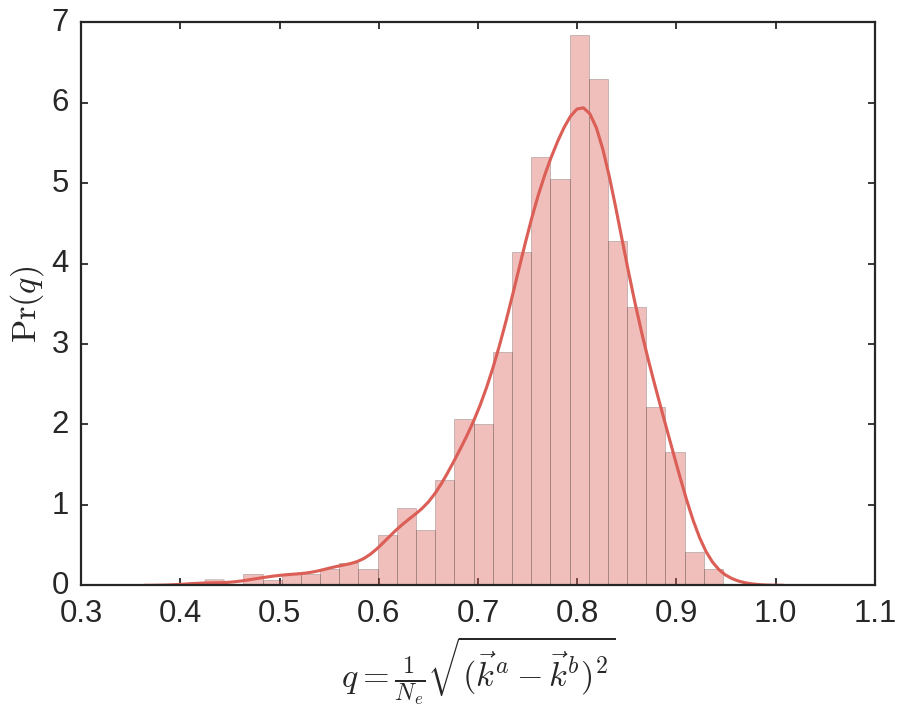

In [28]:
overlap = []

for i in range(np.min([len(K1_list), len(K2_list)])):
    
#     q = 1.0 / net.NE * np.sqrt(np.sum((K1_list[i] - K2_list[i])**2))
    q = K1_list[i].dot(K2_list[i]) / la.norm(K1_list[i]) / la.norm(K2_list[i])
    
#     print "Overlap:", q
    
    overlap.append(q)


fig, ax = plt.subplots(1,1)
sns.distplot(overlap, ax=ax)

ax.set_ylabel(r"$\mathrm{Pr}(q)$")
ax.set_xlabel(r"$q=\frac{1}{N_e}\sqrt{(\vec{k}^a-\vec{k}^b)^2}$")
# ax.set_yscale('log')
# ax.set_xlim(0, 0.2)
plt.show()

In [284]:
def stepK(K, k_up, k_low):
    sigma = 0.1
    kmax = np.minimum(k_up, K*net.eq_length+sigma)    
    kmin = np.maximum(k_low, K*net.eq_length-sigma)
    return ((kmax - kmin) * rand.random(net.NE) + kmin) / net.eq_length

def probRatio(Kp, K, k_up, k_low):
    sigma = 0.1
    kpmax = np.minimum(k_up, K*net.eq_length+sigma)    
    kpmin = np.maximum(k_low, K*net.eq_length-sigma)
    
    kmax = np.minimum(k_up, Kp*net.eq_length+sigma)    
    kmin = np.maximum(k_low, Kp*net.eq_length-sigma)
    
    ratio = (kpmax - kpmin) / (kmax - kmin)
    
    return np.prod(ratio)

In [286]:
rand.seed(13)


Nsteps = 1000

k_low = 1e-6
k_up = 1e0

beta = 10.0

K1 = ((k_up - k_low) * rand.random(net.NE) + k_low) / net.eq_length
K2 = ((k_up - k_low) * rand.random(net.NE) + k_low) / net.eq_length

E1 = tuner.func(K1)
E2 = tuner.func(K2)

print "Initial Energies:", E1, E2

overlap = []

for n in range(Nsteps):
    
    if n % 10 == 0:
        print "Step:", n
    
    n1 = 0
    while True:
        n1 +=1
        K1_new = stepK(K1, k_up, k_low)
        E1_new = tuner.func(K1_new)
        
        p1 = np.exp(-beta*(E1_new - E1)) * probRatio(K1_new, K1, k_up, k_low)
        
#         print p1, E1, E1_new - E1
        
        if p1 > rand.random():
            K1 = K1_new
            E1 = E1_new
                        
#             print n1, E1
                
            if E1 == 0.0:
                break
     
    n2 = 0
    while True:
        n2 += 1
        K2_new = stepK(K2, k_up, k_low)
        E2_new = tuner.func(K2_new)
        
        p2 = np.exp(-beta*(E2_new - E2)) * probRatio(K2_new, K2, k_up, k_low)
        
        if p2 > rand.random():
            K2 = K2_new
            E2 = E2_new
                
            if E2 == 0.0:
#                 print n2
                break
            
#     print "MC Steps:", n1, n2
#     print "Energies:", E1, E2
    
    q = 1.0 / net.NE * np.sqrt(np.sum((K1 - K2)**2))
    
#     print "Overlap:", q
    
    overlap.append(q)
    
    

Initial Energies: 44.5568977738 3.76099298803
Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step: 180
Step: 190
Step: 200
Step: 210
Step: 220
Step: 230
Step: 240
Step: 250
Step: 260
Step: 270
Step: 280
Step: 290
Step: 300
Step: 310
Step: 320
Step: 330
Step: 340
Step: 350
Step: 360
Step: 370
Step: 380
Step: 390
Step: 400
Step: 410
Step: 420
Step: 430
Step: 440
Step: 450
Step: 460
Step: 470
Step: 480
Step: 490
Step: 500
Step: 510
Step: 520
Step: 530
Step: 540
Step: 550
Step: 560
Step: 570
Step: 580
Step: 590
Step: 600
Step: 610
Step: 620
Step: 630
Step: 640
Step: 650
Step: 660
Step: 670
Step: 680
Step: 690
Step: 700
Step: 710
Step: 720
Step: 730
Step: 740
Step: 750
Step: 760
Step: 770
Step: 780
Step: 790
Step: 800
Step: 810
Step: 820
Step: 830
Step: 840
Step: 850
Step: 860
Step: 870
Step: 880
Step: 890
Step: 900
Step: 910
Step: 920
Step: 930
Step: 940
Step: 950
Step:

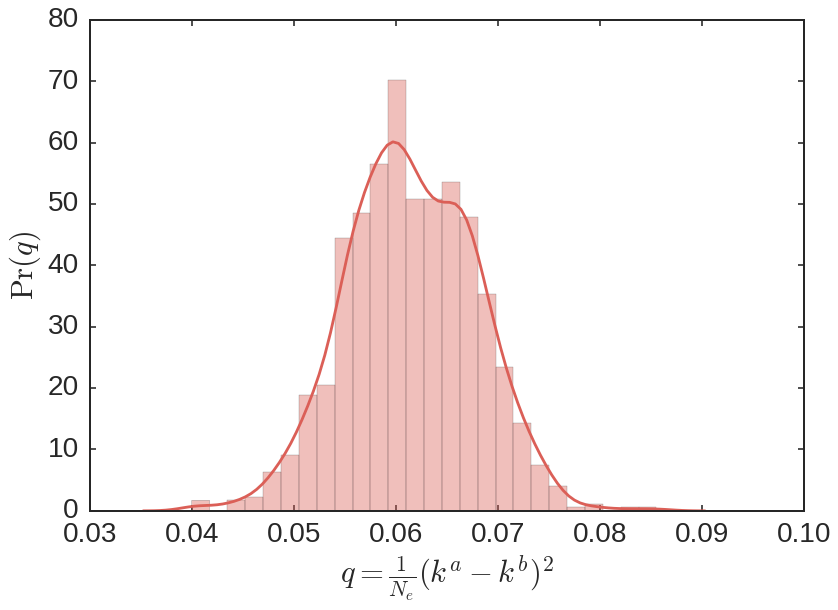

In [272]:
fig, ax = plt.subplots(1,1)
sns.distplot(overlap, ax=ax)

ax.set_ylabel(r"$\mathrm{Pr}(q)$")
ax.set_xlabel(r"$q=\frac{1}{N_e}(k^a-k^b)^2$")
# ax.set_xlim(0, 0.2)
plt.show()